In [1]:
!pip install -r requirements.txt

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
import itertools 

In [5]:
# --- Environment Setup ---
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['JOBLIB_LOKY_BACKEND'] = 'threading'
plt.style.use('ggplot')

In [7]:
file_path = 'Mall_Customers.csv'
df = pd.read_csv(file_path)
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Using min_samples = 4
eps = 0.3677


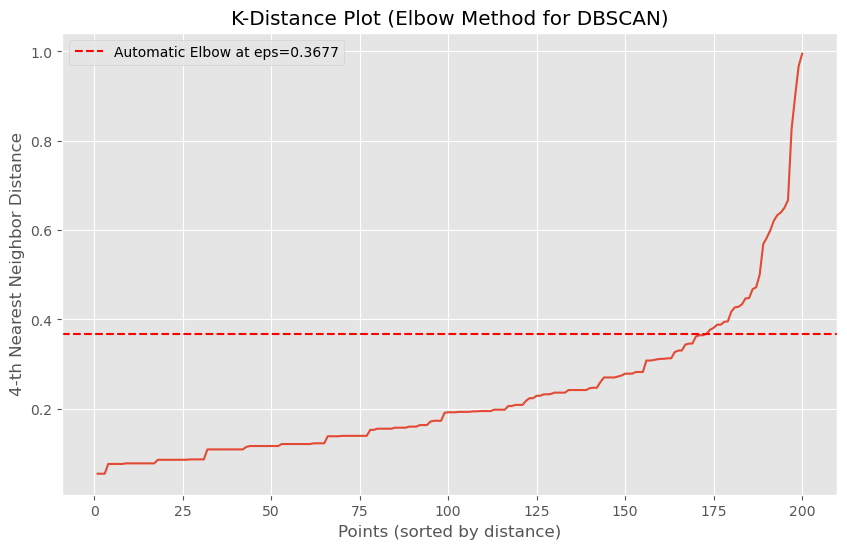

In [9]:
# ---  Find Optimal Epsilon (eps) ---

min_samples = 2 * X_scaled.shape[1] 
print(f"Using min_samples = {min_samples}")

# Calculate distance for each point to its k-th nearest neighbor
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Sort the k-th distances
distances_sorted = np.sort(distances[:, min_samples - 1])
x_range = range(1, len(distances_sorted) + 1)

kneedle = KneeLocator(
    x_range, 
    distances_sorted, 
    curve='convex', 
    direction='increasing'
)
eps_auto = kneedle.elbow_y 

if eps_auto is None:
    eps_auto = 0.3
else:
    print(f"eps = {eps_auto:.4f}")
    
# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(x_range, distances_sorted)
plt.title('K-Distance Plot (Elbow Method for DBSCAN)')
plt.xlabel('Points (sorted by distance)')
plt.ylabel(f'{min_samples}-th Nearest Neighbor Distance')
plt.grid(True)

# Draw the line at the automatically found elbow
plt.axhline(y=eps_auto, c='red', linestyle='--', label=f'Automatic Elbow at eps={eps_auto:.4f}')
plt.legend()


Estimated number of clusters: 3
Estimated number of noise points: 15


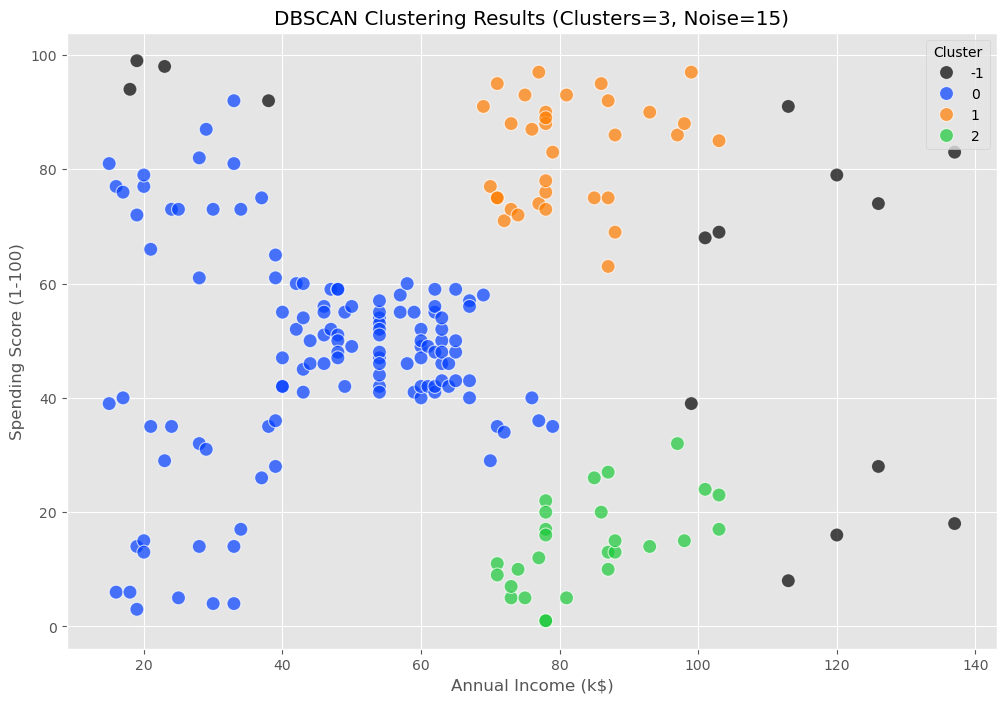

In [11]:
# --- DBSCAN Clustering Results ---

db = DBSCAN(eps=eps_auto, min_samples=min_samples)
y_db = db.fit_predict(X_scaled)

df['DBSCAN_Cluster'] = y_db
unique_labels = np.unique(y_db)
n_clusters_ = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise_ = list(y_db).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')


plt.figure(figsize=(12, 8))

# Create a custom palette
cluster_colors = sns.color_palette('bright', n_colors=n_clusters_)
palette = {label: color for label, color in zip(range(n_clusters_), cluster_colors)}
palette[-1] = (0, 0, 0, 1) # Black for noise

sns.scatterplot(
    data=df,
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='DBSCAN_Cluster',
    palette=palette,
    s=100,
    alpha=0.7,
    legend='full'
)

plt.title(f'DBSCAN Clustering Results (Clusters={n_clusters_}, Noise={n_noise_})')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.grid(True)

In [33]:
# --- Hyperparameter Tuning using Grid Search ---
# Based on k-distance plot, 'eps' is likely between 0.2 and 0.5
eps_range = np.arange(0.2, 0.6, 0.01) 
min_samples_range = [4, 5, 6, 7]

# Store results
best_score = -1.0
best_params = {}
best_n_clusters = 0

# 2. Loop through all combinations
param_combinations = list(itertools.product(eps_range, min_samples_range))

for eps, min_s in param_combinations:
    # Run DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_s)
    labels = db.fit_predict(X_scaled)
    
    # 3. Check for valid clustering (must have at least 2 clusters)
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    
    if n_clusters > 1:
        # 4. Calculate Silhouette Score
        score = silhouette_score(X_scaled, labels)
        
        # 5. Find the best score
        if score > best_score:
            best_score = score
            best_eps = eps
            best_min_samples = min_s
            best_params = {'eps': eps, 'min_samples': min_s}
            best_n_clusters = n_clusters

if best_score == -1.0:
    print("Grid search found no valid clusters (all combinations resulted in 1 cluster or noise).")
else:
    print(f"Best parameters found: {best_params}")
    print(f"  - Best Silhouette Score: {best_score:.4f}")
    print(f"  - Clusters found with these params: {best_n_clusters}")

Best parameters found: {'eps': 0.36000000000000015, 'min_samples': 5}
  - Best Silhouette Score: 0.4430
  - Clusters found with these params: 6


Estimated number of clusters: 6
Estimated number of noise points: 21


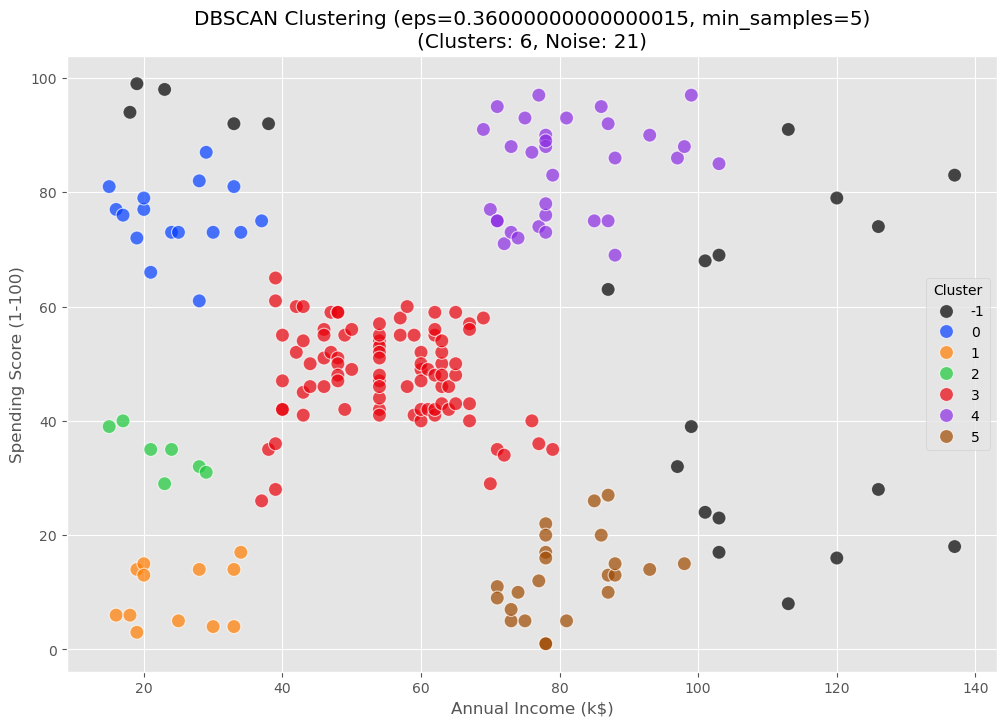

In [34]:
# --- Apply Optimal Parameters from Grid Search ---
db = DBSCAN(eps=best_eps, min_samples=best_min_samples)
y_db = db.fit_predict(X_scaled)

# Add cluster labels to dataframe
df['DBSCAN_Cluster'] = y_db

unique_labels = np.unique(y_db)
# Get all labels that are NOT -1 (noise)
cluster_labels = [label for label in unique_labels if label != -1]

n_clusters_ = len(cluster_labels)

n_noise_ = list(y_db).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

plt.figure(figsize=(12, 8))

cluster_colors = sns.color_palette('bright', n_colors=n_clusters_)
palette = {label: color for label, color in zip(cluster_labels, cluster_colors)}

palette[-1] = (0, 0, 0, 1) 

sns.scatterplot(
    data=df,
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='DBSCAN_Cluster',
    palette=palette,
    s=100,
    alpha=0.7,
    legend='full'
)

plt.title(f'DBSCAN Clustering (eps={best_eps}, min_samples={best_min_samples})\n(Clusters: {n_clusters_}, Noise: {n_noise_})')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.grid(True)